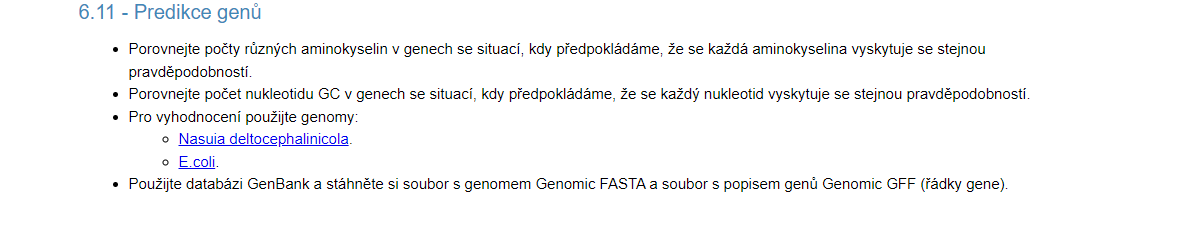

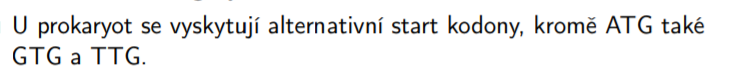

In [1]:
import re
from collections import Counter

# 

In [2]:
path_coli = './data/e_coli/ncbi-genomes-2021-11-16/GCA_000005845.2_ASM584v2_genomic.fna'

In [3]:
path_nasuia = './data/nasuia_deltocephalinicola/ncbi-genomes-2021-11-16/GCA_002290365.1_ASM229036v1_genomic.fna'

In [4]:
def load(path):
    with open(path) as f:
        lines = f.readlines()
        return lines

In [5]:
def preprocess(data):
    res = []
    for line in data[1:]:
        res.append(line.replace("\n", ""))
    return "".join(res)

In [6]:
def load_and_preprocess(path):
    loaded_data = load(path)
    return preprocess(loaded_data)

In [7]:
coli = load_and_preprocess(path_coli);

In [8]:
nasuia = load_and_preprocess(path_nasuia);

In [9]:
print(len(coli))

4641652


In [10]:
print(len(nasuia))

144602


## Configuration

In [11]:
size = 30

## Translator

In [12]:
aminoacid_replacements = {
    "ATG":"M",
    "TTT":"F",
    "TTC":"F",
    "TTA":"L",
    "TTG":"L",
    "TCT":"S",
    "TCC":"S",
    "TCA":"S",
    "TCG":"S",
    "TAT":"Y",
    "TAC":"Y",
    "TGT":"C",
    "TGC":"C",
    "TGG":"W",
    "CTT":"L",
    "CTC":"L",
    "CTA":"L",
    "CTG":"L",
    "CCT":"P",
    "CCC":"P",
    "CCA":"P",
    "CCG":"P",
    "CAT":"H",
    "CAC":"H",
    "CAA":"Q",
    "CAG":"Q",
    "CGT":"R",
    "CGC":"R",
    "CGA":"R",
    "CGG":"R",
    "ATT":"I",
    "ATC":"I",
    "ATA":"I",
    "ACT":"T",
    "ACC":"T",
    "ACA":"T",
    "ACG":"T",    
    "AAT":"N",
    "AAC":"N",
    "AAA":"K",
    "AAG":"K",
    "AGT":"S",
    "AGC":"S",
    "AGA":"R",
    "AGG":"R",
    "GTT":"V",
    "GTC":"V",
    "GTA":"V",
    "GTG":"V",
    "GCT":"A",
    "GCC":"A",
    "GCA":"A",
    "GCG":"A",
    "GAT":"D",
    "GAC":"D",
    "GAA":"E",
    "GAG":"E",
    "GGT":"G",
    "GGC":"G",
    "GGA":"G",
    "GGG":"G",
    "TAA":"",
    "TAG":"",
    "TGA":"",
}

In [13]:
def create_translator(dic=aminoacid_replacements):
    def translate_to_amino_acid(gene):
        com = gene
        l = list(range(0, len(com), 3))
        acids = []
        for i in range(len(l) - 1):
            start = l[i]
            stop = l[i+1]
            g = com[start:stop].upper()
            acid = dic.get(g, "EMPTY")
            acids.append(acid)
        return ''.join(acids)
    return translate_to_amino_acid

In [14]:
trans = create_translator(aminoacid_replacements)

In [34]:
trans

<function __main__.create_translator.<locals>.translate_to_amino_acid(gene)>

## Implementation

In [35]:
def create_neighborhood(args, size, reference):
    start, end, seq = args
    try:
        return reference[(start-size):(end+size)]
    except:
        return None

In [36]:
def div_by_n(n, k):
    res = n % k == 0
    print(f'{n} % {k} == 0 ? -> {res}')
    return not res

In [37]:
def search(reference, seqs, size):
    my_bois = []
    if div_by_n(size, 3):
        return
    for s in seqs:
        for m in re.finditer(s, reference):
            args = (m.start(), m.end(), s)
            neig = create_neighborhood(args, size, reference)
            my_bois.append(neig)
    return list(filter(lambda x: x is not None, my_bois))

In [38]:
sequences = search(nasuia, ['ATG'], 15)

15 % 3 == 0 ? -> True


In [93]:
from collections import Counter
import pandas as pd

In [59]:
def statistic_on_nukleotids(sequence):
    nukleotids = list(sequence)
    counted = Counter(nukleotids)
    return dict(counted)

In [74]:
def statistic_on_acids(sequence):
    translated = list(trans(sequence))
    counted = Counter(translated)
    return dict(counted) 

In [89]:
def aggregate_statistic(index_to_stats):
    res = {}
    for index, dic_stat in index_to_stats.items():
        for k, v in dic_stat.items():
            res[k] = res.get(k, 0) + v
    #print(index_to_stats)
    return res

In [90]:
def make_stats(sequences, func):
    stats = {}
    for index, v in enumerate(sequences):
        stats[index] = func(v)
    return stats, aggregate_statistic(stats)

# Nasuia deltocephalinicola

In [98]:
nasuia_sequences = search(nasuia, ['ATG'], 15)

15 % 3 == 0 ? -> True


### Porovnejte počty různých aminokyselin v genech se situací, kdy předpokládáme, že se každá aminokyselina vyskytuje se stejnou pravděpodobností.

In [111]:
stats, aggrergated_stats = make_stats(nasuia_sequences, statistic_on_acids);
pd.DataFrame.from_dict(aggrergated_stats, orient='index', columns=['Count']).sort_values(by='Count')

,Count
W,55
C,145
A,151
P,165
H,183
D,193
G,209
Q,242
E,270
R,315


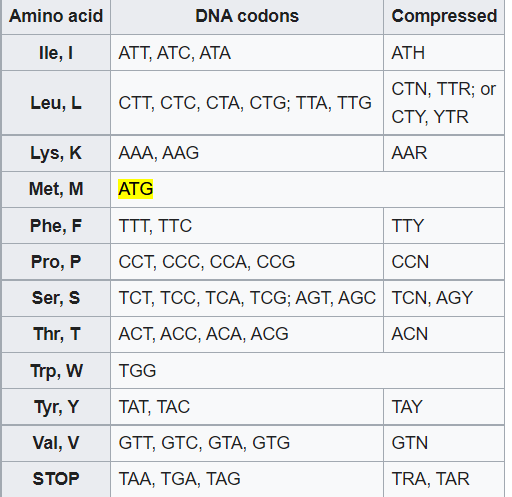

### Porovnejte počet nukleotidu GC v genech se situací, kdy předpokládáme, že se každý nukleotid vyskytuje se stejnou pravděpodobností.

In [112]:
stats, aggrergated_stats = make_stats(nasuia_sequences, statistic_on_nukleotids)
pd.DataFrame.from_dict(aggrergated_stats, orient='index', columns=['Count']).sort_values(by='Count')

,Count
C,3568
G,6480
T,19713
A,20168


# E.coli

In [113]:
coli_sequences = search(coli, ['ATG'], 15)

15 % 3 == 0 ? -> True


### Porovnejte počty různých aminokyselin v genech se situací, kdy předpokládáme, že se každá aminokyselina vyskytuje se stejnou pravděpodobností.

In [114]:
stats, aggrergated_stats = make_stats(coli_sequences, statistic_on_acids);
pd.DataFrame.from_dict(aggrergated_stats, orient='index', columns=['Count']).sort_values(by='Count')

,Count
W,13176
Y,14088
H,16447
D,17762
C,19678
E,19828
Q,24239
N,25002
F,28245
K,30822


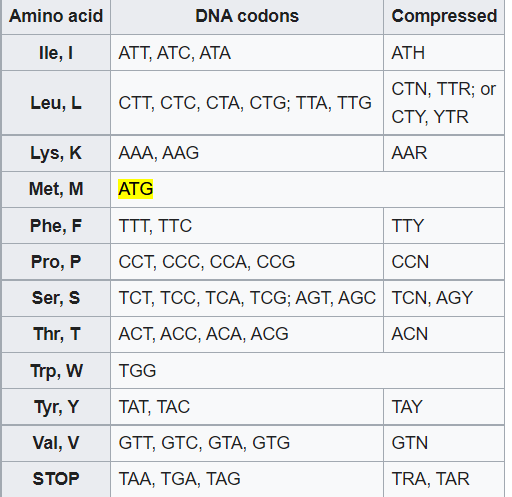

### Porovnejte počet nukleotidu GC v genech se situací, kdy předpokládáme, že se každý nukleotid vyskytuje se stejnou pravděpodobností.


In [115]:
stats, aggrergated_stats = make_stats(coli_sequences, statistic_on_nukleotids)
pd.DataFrame.from_dict(aggrergated_stats, orient='index', columns=['Count']).sort_values(by='Count')

,Count
C,567175
T,638071
A,646388
G,665672
